## Generate Static Graphs

These are the input parameters for the notebook. They will be automatically changed when the scripts to generate monthly statistics are run. You can modify them manually to generate multiple plots locally as well.

Pass in `None` to remove the filters and plot all data. This is not recommended for production settings, but might be useful for reports based on data snapshots.

In [1]:
year = 2021
month = 9
program = "prepilot"
study_type = None

In [2]:
from collections import defaultdict
import datetime
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import emission.core.get_database as edb
import emission.core.wrapper.entry as ecwe
import emission.storage.decorations.analysis_timeseries_queries as esda
import emission.storage.decorations.trip_queries as esdt
import emission.storage.decorations.timeline as esdl
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt
from plots import *
import scaffolding
from uuid import UUID

sns.set_style("whitegrid")
sns.set()
%matplotlib inline

Connecting to database URL db


In [3]:
# Loading mapping dictionaries from mapping_dictionaries notebook
%store -r df_ei
%store -r dic_re
%store -r dic_pur
%store -r dic_fuel

# convert a dictionary to a defaultdict
dic_re = defaultdict(lambda: 'Other',dic_re)
dic_pur = defaultdict(lambda: 'Other',dic_pur)
dic_fuel = defaultdict(lambda: 'Other',dic_fuel)

## Collect Data From Database

In [4]:
tq = scaffolding.get_time_query(year, month)
participant_ct_df = scaffolding.load_all_participant_trips(program, tq)
labeled_ct = scaffolding.filter_labeled_trips(participant_ct_df)
expanded_ct = scaffolding.expand_userinputs(labeled_ct)
expanded_ct = scaffolding.data_quality_check(expanded_ct)

[UUID('863e9c6c-8ec0-48c4-b765-3f73d839c85b'),
 UUID('c6e4db31-c18b-4355-b02a-7dd97deca70b'),
 UUID('c6807997-194c-4c52-8a8f-a8c1f6ee1595'),
 UUID('e9e479e9-5c3f-4345-a885-dadb7999b312'),
 UUID('6656c04c-6cba-4c18-9fed-805eaa529741'),
 UUID('9910245f-ee4e-4cca-ab4c-dd2312eb0d5d'),
 UUID('9b5154d6-3f45-4778-9ebc-a8e5e3ff2e98'),
 UUID('509b9093-9093-4e98-8eb1-20b58ed9bd8c'),
 UUID('e192b8a0-0b6c-4222-9685-1c93785deaf7'),
 UUID('2cd5668a-c905-4e2e-b2c8-8bb4ed94bc6d'),
 UUID('56e23e21-6152-4f59-9253-50bd28a5d7f9'),
 UUID('840297ae-3948-4e26-bfeb-e83ee30c5b3e'),
 UUID('d7a732f4-a864-4bcb-b8de-dfc8be242fb2'),
 UUID('5ad862e7-9a63-41f6-9f28-c0096fe884da'),
 UUID('21c78a1c-6df2-4097-b289-5a784610991b'),
 UUID('e4cfb2a8-f600-4268-9756-9985e234636e'),
 UUID('fc68a5bb-0a7b-4b63-86b3-f08a69ead36f'),
 UUID('321b7e37-a9a1-4775-9ebb-b5dc88e183fb'),
 UUID('28cb1dde-8551-4bba-bfd4-2145bdaf7e0a'),
 UUID('e35e6510-7a34-496d-b49f-a5a0b41a1e9e'),
 UUID('d3735ba2-12dd-4c76-8e16-75dca7bdcb6f'),
 UUID('97953a

Loaded all confirmed trips of length 11836


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationDistFilter,1.630502e+09,2021-09-01T07:15:17.000028-06:00,"{'type': 'Point', 'coordinates': [-107.8694824...",612f7d247b8bfbc09d1acd26,1.630501e+09,2021-09-01T06:57:24.690419-06:00,"{'type': 'Point', 'coordinates': [-107.8518209...",1072.309608,11851.503432,...,9,1,7,15,17,2,America/Denver,612f7d9d7b8bfbc09d1acd60,c6e4db31-c18b-4355-b02a-7dd97deca70b,1.630502e+09
1,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:52:37.999908-06:00,"{'type': 'Point', 'coordinates': [-107.8689998...",612f8b1fe68d63d2fb8d7a1a,1.630504e+09,2021-09-01T07:40:11.520930-06:00,"{'type': 'Point', 'coordinates': [-107.8835057...",746.478978,3711.798398,...,9,1,7,52,37,2,America/Denver,612f8b64e68d63d2fb8d7a49,5ad862e7-9a63-41f6-9f28-c0096fe884da,1.630506e+09
2,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:49:45.606963-06:00,"{'type': 'Point', 'coordinates': [-107.8600675...",612f8b3786733a8f9a900db7,1.630503e+09,2021-09-01T07:35:10.901781-06:00,"{'type': 'Point', 'coordinates': [-107.8720599...",874.705182,10355.326280,...,9,1,7,49,45,2,America/Denver,612f8b6686733a8f9a900df4,c6807997-194c-4c52-8a8f-a8c1f6ee1595,1.630506e+09
3,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:53:28.001725-06:00,"{'type': 'Point', 'coordinates': [-107.8853829...",612f8b2d5f105b1932cef7a8,1.630504e+09,2021-09-01T07:46:08.299580-06:00,"{'type': 'Point', 'coordinates': [-107.8694824...",439.702145,2127.880652,...,9,1,7,53,28,2,America/Denver,612f8b8f5f105b1932cef7cd,c6e4db31-c18b-4355-b02a-7dd97deca70b,1.630506e+09
4,DwellSegmentationTimeFilter,1.630506e+09,2021-09-01T08:26:33.949000-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",612f99122648c522f963a886,1.630506e+09,2021-09-01T08:13:23.524000-06:00,"{'type': 'Point', 'coordinates': [-107.9060695...",790.425000,6186.329651,...,9,1,8,26,33,2,America/Denver,612f998d2648c522f963a8ba,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630509e+09


After filtering, found 11836 participant trips 


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
0,DwellSegmentationDistFilter,1.630502e+09,2021-09-01T07:15:17.000028-06:00,"{'type': 'Point', 'coordinates': [-107.8694824...",612f7d247b8bfbc09d1acd26,1.630501e+09,2021-09-01T06:57:24.690419-06:00,"{'type': 'Point', 'coordinates': [-107.8518209...",1072.309608,11851.503432,...,9,1,7,15,17,2,America/Denver,612f7d9d7b8bfbc09d1acd60,c6e4db31-c18b-4355-b02a-7dd97deca70b,1.630502e+09
1,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:52:37.999908-06:00,"{'type': 'Point', 'coordinates': [-107.8689998...",612f8b1fe68d63d2fb8d7a1a,1.630504e+09,2021-09-01T07:40:11.520930-06:00,"{'type': 'Point', 'coordinates': [-107.8835057...",746.478978,3711.798398,...,9,1,7,52,37,2,America/Denver,612f8b64e68d63d2fb8d7a49,5ad862e7-9a63-41f6-9f28-c0096fe884da,1.630506e+09
2,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:49:45.606963-06:00,"{'type': 'Point', 'coordinates': [-107.8600675...",612f8b3786733a8f9a900db7,1.630503e+09,2021-09-01T07:35:10.901781-06:00,"{'type': 'Point', 'coordinates': [-107.8720599...",874.705182,10355.326280,...,9,1,7,49,45,2,America/Denver,612f8b6686733a8f9a900df4,c6807997-194c-4c52-8a8f-a8c1f6ee1595,1.630506e+09
3,DwellSegmentationDistFilter,1.630504e+09,2021-09-01T07:53:28.001725-06:00,"{'type': 'Point', 'coordinates': [-107.8853829...",612f8b2d5f105b1932cef7a8,1.630504e+09,2021-09-01T07:46:08.299580-06:00,"{'type': 'Point', 'coordinates': [-107.8694824...",439.702145,2127.880652,...,9,1,7,53,28,2,America/Denver,612f8b8f5f105b1932cef7cd,c6e4db31-c18b-4355-b02a-7dd97deca70b,1.630506e+09
4,DwellSegmentationTimeFilter,1.630506e+09,2021-09-01T08:26:33.949000-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",612f99122648c522f963a886,1.630506e+09,2021-09-01T08:13:23.524000-06:00,"{'type': 'Point', 'coordinates': [-107.9060695...",790.425000,6186.329651,...,9,1,8,26,33,2,America/Denver,612f998d2648c522f963a8ba,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630509e+09


After filtering, found 5458 labeled trips


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_month,end_local_dt_day,end_local_dt_hour,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts
4,DwellSegmentationTimeFilter,1.630506e+09,2021-09-01T08:26:33.949000-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",612f99122648c522f963a886,1.630506e+09,2021-09-01T08:13:23.524000-06:00,"{'type': 'Point', 'coordinates': [-107.9060695...",790.425000,6186.329651,...,9,1,8,26,33,2,America/Denver,612f998d2648c522f963a8ba,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630509e+09
7,DwellSegmentationTimeFilter,1.630512e+09,2021-09-01T10:07:39.824000-06:00,"{'type': 'Point', 'coordinates': [-107.8598234...",612fa723ce8c93ad2e54b60a,1.630511e+09,2021-09-01T09:48:45.703800-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",1134.120200,10998.235798,...,9,1,10,7,39,2,America/Denver,612fa72cce8c93ad2e54b646,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630513e+09
8,DwellSegmentationDistFilter,1.630512e+09,2021-09-01T09:55:54.618285-06:00,"{'type': 'Point', 'coordinates': [-107.8724742...",612fa74132ef04cc63d731fc,1.630510e+09,2021-09-01T09:29:24.795737-06:00,"{'type': 'Point', 'coordinates': [-107.8559166...",1589.822548,5695.277053,...,9,1,9,55,54,2,America/Denver,612fa78b32ef04cc63d73258,d7a732f4-a864-4bcb-b8de-dfc8be242fb2,1.630513e+09
11,DwellSegmentationTimeFilter,1.630514e+09,2021-09-01T10:29:08-06:00,"{'type': 'Point', 'coordinates': [-107.8653703...",612fc32eff291becf892aedd,1.630513e+09,2021-09-01T10:17:37.157156-06:00,"{'type': 'Point', 'coordinates': [-107.8598234...",690.842844,1445.210704,...,9,1,10,29,8,2,America/Denver,612fc331ff291becf892af5c,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630520e+09
12,DwellSegmentationTimeFilter,1.630516e+09,2021-09-01T11:05:06.885000-06:00,"{'type': 'Point', 'coordinates': [-107.8600612...",612fc32eff291becf892aedf,1.630514e+09,2021-09-01T10:32:08-06:00,"{'type': 'Point', 'coordinates': [-107.8653703...",1978.885000,926.533108,...,9,1,11,5,6,2,America/Denver,612fc331ff291becf892af5d,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630520e+09


,mode_confirm,purpose_confirm,replaced_mode
4,drove_alone,home,NaN
7,drove_alone,work,NaN
8,bike,work,bike
11,drove_alone,at_work,NaN
12,drove_alone,work,NaN


After expanding, columns went from 38 -> 41


,source,end_ts,end_fmt_time,end_loc,raw_trip,start_ts,start_fmt_time,start_loc,duration,distance,...,end_local_dt_minute,end_local_dt_second,end_local_dt_weekday,end_local_dt_timezone,_id,user_id,metadata_write_ts,mode_confirm,purpose_confirm,replaced_mode
4,DwellSegmentationTimeFilter,1.630506e+09,2021-09-01T08:26:33.949000-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",612f99122648c522f963a886,1.630506e+09,2021-09-01T08:13:23.524000-06:00,"{'type': 'Point', 'coordinates': [-107.9060695...",790.425000,6186.329651,...,26,33,2,America/Denver,612f998d2648c522f963a8ba,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630509e+09,drove_alone,home,NaN
7,DwellSegmentationTimeFilter,1.630512e+09,2021-09-01T10:07:39.824000-06:00,"{'type': 'Point', 'coordinates': [-107.8598234...",612fa723ce8c93ad2e54b60a,1.630511e+09,2021-09-01T09:48:45.703800-06:00,"{'type': 'Point', 'coordinates': [-107.8644269...",1134.120200,10998.235798,...,7,39,2,America/Denver,612fa72cce8c93ad2e54b646,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630513e+09,drove_alone,work,NaN
8,DwellSegmentationDistFilter,1.630512e+09,2021-09-01T09:55:54.618285-06:00,"{'type': 'Point', 'coordinates': [-107.8724742...",612fa74132ef04cc63d731fc,1.630510e+09,2021-09-01T09:29:24.795737-06:00,"{'type': 'Point', 'coordinates': [-107.8559166...",1589.822548,5695.277053,...,55,54,2,America/Denver,612fa78b32ef04cc63d73258,d7a732f4-a864-4bcb-b8de-dfc8be242fb2,1.630513e+09,bike,work,bike
11,DwellSegmentationTimeFilter,1.630514e+09,2021-09-01T10:29:08-06:00,"{'type': 'Point', 'coordinates': [-107.8653703...",612fc32eff291becf892aedd,1.630513e+09,2021-09-01T10:17:37.157156-06:00,"{'type': 'Point', 'coordinates': [-107.8598234...",690.842844,1445.210704,...,29,8,2,America/Denver,612fc331ff291becf892af5c,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630520e+09,drove_alone,at_work,NaN
12,DwellSegmentationTimeFilter,1.630516e+09,2021-09-01T11:05:06.885000-06:00,"{'type': 'Point', 'coordinates': [-107.8600612...",612fc32eff291becf892aedf,1.630514e+09,2021-09-01T10:32:08-06:00,"{'type': 'Point', 'coordinates': [-107.8653703...",1978.885000,926.533108,...,5,6,2,America/Denver,612fc331ff291becf892af5d,e9e479e9-5c3f-4345-a885-dadb7999b312,1.630520e+09,drove_alone,work,NaN


In [5]:
# Mapping new labels with dictionaries
expanded_ct['Trip_purpose']= expanded_ct['purpose_confirm'].map(dic_pur)
expanded_ct['Mode_confirm']= expanded_ct['mode_confirm'].map(dic_re)
expanded_ct['Replaced_mode']= expanded_ct['replaced_mode'].map(dic_re)

# Mapping fuel
expanded_ct['Mode_confirm_fuel']= expanded_ct['Mode_confirm'].map(dic_fuel)
expanded_ct['Replaced_mode_fuel']= expanded_ct['Replaced_mode'].map(dic_fuel)

# Change meters to miles
scaffolding.unit_conversions(expanded_ct)

# Calculate energy impact
expanded_ct = scaffolding.energy_intensity(expanded_ct, df_ei, 'distance_miles', 'Replaced_mode', 'Mode_confirm')
expanded_ct = scaffolding.energy_impact_kWH(expanded_ct, 'distance_miles', 'Replaced_mode', 'Mode_confirm')
expanded_ct = scaffolding.CO2_impact_lb(expanded_ct, 'distance_miles', 'Replaced_mode', 'Mode_confirm')

In [6]:
file_suffix = scaffolding.get_file_suffix(year, month, program)
quality_text = scaffolding.get_quality_text(participant_ct_df, expanded_ct)

_2021_09_prepilot
Based on 5458 confirmed trips from 90 users
of 11836 total trips from 123 users (46.11%)


## Energy Impacts (kWH)

## Distance vs. Energy_Impact (kWH) by Mode_confirm

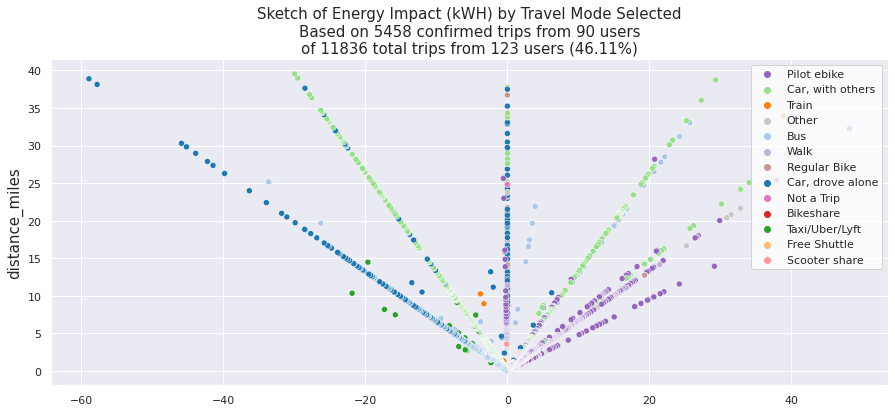

In [7]:
data=expanded_ct.loc[(expanded_ct['distance_miles'] <= 40)].sort_values(by=['Energy_Impact(kWH)'], ascending=False)   
x='Energy_Impact(kWH)'
y='distance_miles'
legend ='Mode_confirm'
plot_title="Sketch of Energy Impact (kWH) by Travel Mode Selected\n%s" % quality_text
file_name ='sketch_distance_energy_impact%s.png' % file_suffix
distancevsenergy(data,x,y,legend,plot_title,file_name)

## Energy_Impact (kWH)

In [8]:
#eirp : energy impact replaced_mode
eirc=expanded_ct.groupby('Replaced_mode').agg({'Energy_Impact(kWH)': ['sum', 'mean']},)
eirc.columns = ['Sketch of Total Energy_Impact(kWH)', 'Sketch of Average Energy_Impact(kWH)']
eirc = eirc.reset_index()
eirc = eirc.sort_values(by=['Sketch of Total Energy_Impact(kWH)'], ascending=False)
eirc['boolean'] = eirc['Sketch of Total Energy_Impact(kWH)'] > 0

#eimc : energy impact mode_confirm
eimc=expanded_ct.groupby('Mode_confirm').agg({'Energy_Impact(kWH)': ['sum', 'mean']},)
eimc.columns = ['Sketch of Total Energy_Impact(kWH)', 'Sketch of Average Energy_Impact(kWH)']
eimc = eimc.reset_index()
eimc = eimc.sort_values(by=['Sketch of Total Energy_Impact(kWH)'], ascending=False)


subset1 = eirc [['Replaced_mode', 'Sketch of Total Energy_Impact(kWH)']].copy()
subset1.rename(columns = {'Replaced_mode':'Transport Mode','Sketch of Total Energy_Impact(kWH)':'Replaced_Mode' }, inplace=True)

subset2 = eimc [['Mode_confirm', 'Sketch of Total Energy_Impact(kWH)']].copy()
subset2.rename(columns = {'Mode_confirm':'Transport Mode','Sketch of Total Energy_Impact(kWH)':'Mode_Confirm' }, inplace=True)

df_plot = pd.merge(subset1, subset2, on="Transport Mode")
df = pd.melt(df_plot , id_vars=['Transport Mode'], value_vars=['Replaced_Mode','Mode_Confirm'], var_name='selection')
df.rename(columns = {'value':'Energy Impact (kWH)'}, inplace = True)

In [9]:
df

,Transport Mode,selection,Energy Impact (kWH)
0,"Car, drove alone",Replaced_Mode,8898.636
1,Taxi/Uber/Lyft,Replaced_Mode,1672.956
2,Bus,Replaced_Mode,825.908
3,"Car, with others",Replaced_Mode,443.904
4,Scooter share,Replaced_Mode,0.239
5,Free Shuttle,Replaced_Mode,0.000
6,Train,Replaced_Mode,-25.481
7,Bikeshare,Replaced_Mode,-34.934
8,Walk,Replaced_Mode,-301.476
9,Regular Bike,Replaced_Mode,-575.558


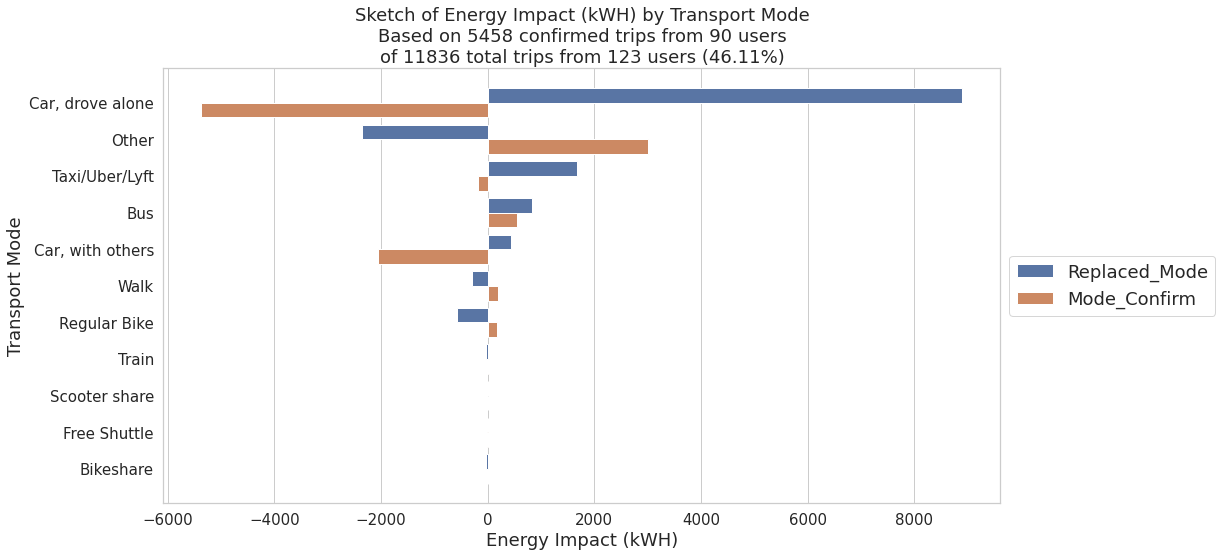

In [10]:
df= df.sort_values(by=['Energy Impact (kWH)'], ascending=False)
x= 'Energy Impact (kWH)'
y= 'Transport Mode'
color = 'selection'
plot_title="Sketch of Energy Impact (kWH) by Transport Mode\n%s" % quality_text
file_name ='sketch_all_energy_impact%s.png' % file_suffix
overeall_energy_impact(x,y,color,df,plot_title,file_name)

## Sketch of Total Energy_Impact (kWH) by Replaced_mode

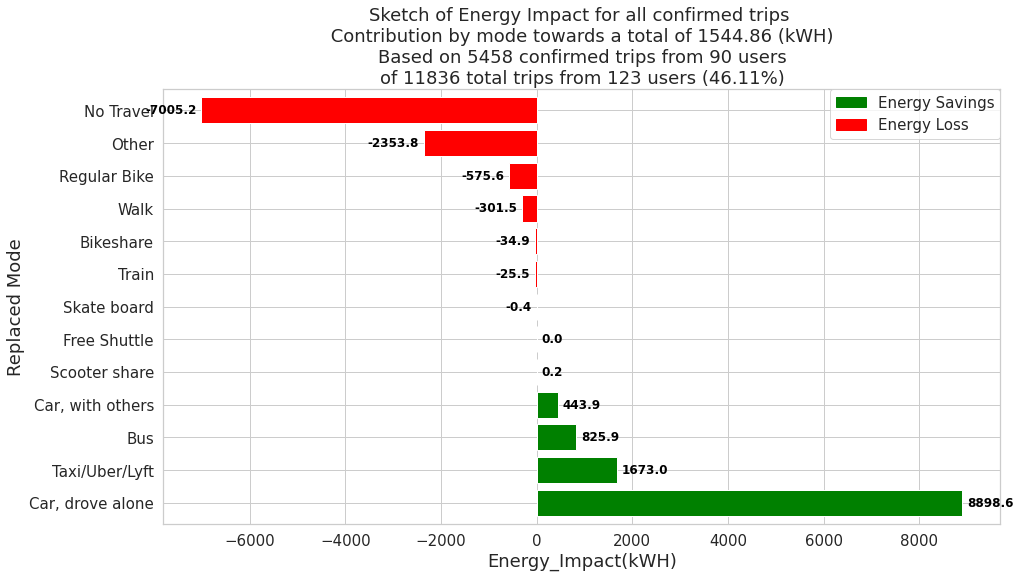

In [11]:
net_energy_saved = round(sum(eirc['Sketch of Total Energy_Impact(kWH)']), 2)

x = eirc['Sketch of Total Energy_Impact(kWH)']
y = eirc['Replaced_mode']
color =eirc['boolean']

plot_title="Sketch of Energy Impact for all confirmed trips \n Contribution by mode towards a total of %s (kWH) \n%s" % (net_energy_saved, quality_text)
file_name ='sketch_all_mode_energy_impact%s.png' % file_suffix
energy_impact(x,y,color,plot_title,file_name)

## Sketch of Energy Impact by E-bike trips

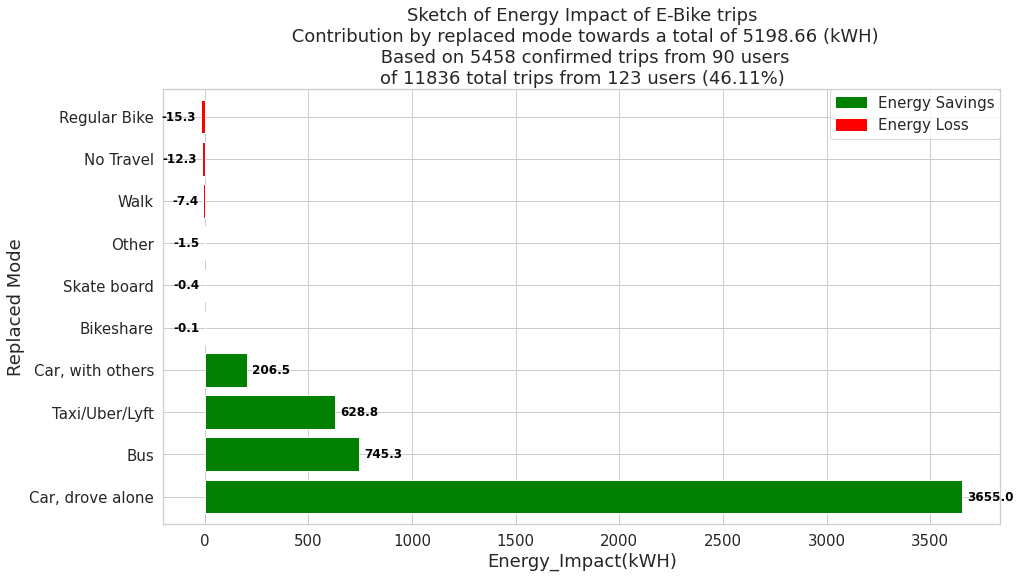

In [12]:
data_eb = expanded_ct.query("Mode_confirm == 'Pilot ebike'")
# ebei : ebike energy impact
ebei=data_eb.groupby('Replaced_mode').agg({'Energy_Impact(kWH)': ['sum', 'mean']},)
ebei.columns = ['Sketch of Total Energy_Impact(kWH)', 'Sketch of Average Energy_Impact(kWH)']
ebei= ebei.reset_index()
ebei = ebei.sort_values(by=['Sketch of Total Energy_Impact(kWH)'], ascending=False)
ebei['boolean'] = ebei['Sketch of Total Energy_Impact(kWH)'] > 0
net_energy_saved = round(sum(ebei['Sketch of Total Energy_Impact(kWH)']), 2)

x = ebei['Sketch of Total Energy_Impact(kWH)']
y = ebei['Replaced_mode']
color =ebei['boolean']

plot_title="Sketch of Energy Impact of E-Bike trips\n Contribution by replaced mode towards a total of %s (kWH)\n %s" % (net_energy_saved, quality_text)
file_name ='sketch_energy_impact_ebike%s.png' % file_suffix
energy_impact(x,y,color,plot_title,file_name)

## CO2 Emissions (lb) Calculation

In [13]:
expanded_ct = scaffolding.CO2_impact_lb(expanded_ct,'distance_miles','Replaced_mode', 'Mode_confirm')

## Sketch of Total CO2 Emissions by Replaced_mode

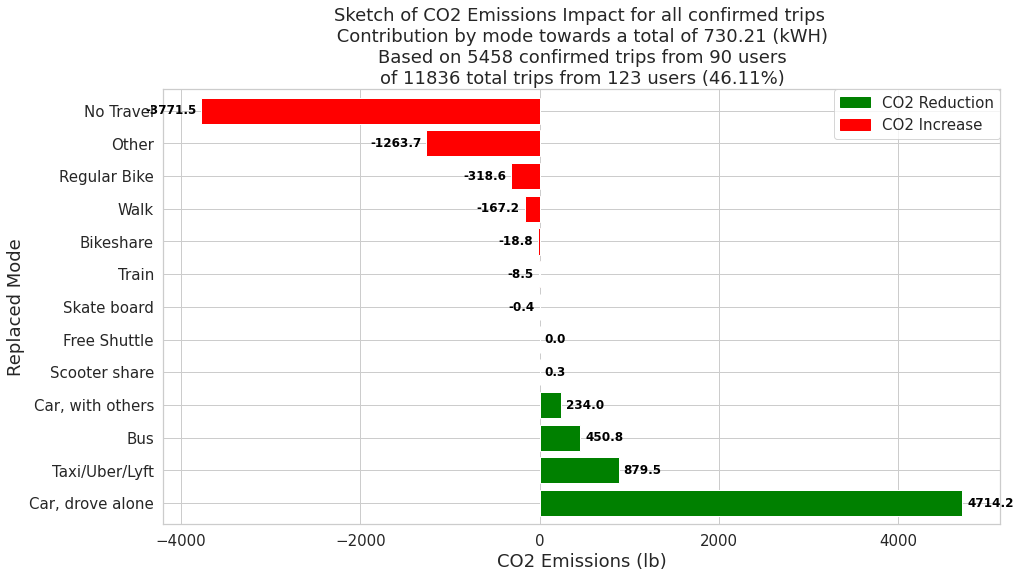

In [14]:
co2rp=expanded_ct.groupby('Replaced_mode').agg({'CO2_Impact(lb)': ['sum', 'mean']},)
co2rp.columns = ['total_lb_CO2_emissions', 'average_lb_CO2_emission']
co2rp = co2rp.reset_index()
co2rp= co2rp.sort_values(by=['total_lb_CO2_emissions'], ascending=False)
co2rp['boolean'] = co2rp['total_lb_CO2_emissions'] > 0


net_CO2_saved = round(sum(co2rp['total_lb_CO2_emissions']), 2)

x = co2rp['total_lb_CO2_emissions']
y = co2rp['Replaced_mode']
color =co2rp['boolean']

plot_title="Sketch of CO2 Emissions Impact for all confirmed trips \n Contribution by mode towards a total of %s (kWH) \n%s" % (net_CO2_saved, quality_text)
file_name ='sketch_all_mode_CO2impact%s.png' % file_suffix
CO2_impact(x,y,color,plot_title,file_name)

## Sketch of  CO2 Emissions Impact by E-bike trips

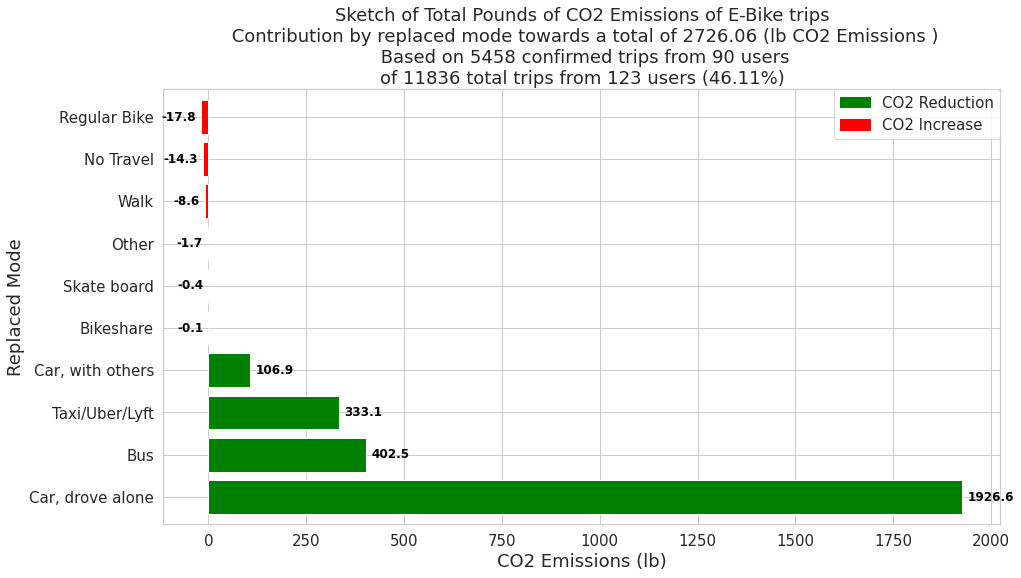

In [15]:
data_eb = expanded_ct.query("Mode_confirm == 'Pilot ebike'")

ebco2=data_eb.groupby('Replaced_mode').agg({'CO2_Impact(lb)': ['sum', 'mean']},)
ebco2.columns = ['total_lb_CO2_emissions', 'average_lb_CO2_emission']
ebco2 = ebco2.reset_index()
ebco2 = ebco2.sort_values(by=['total_lb_CO2_emissions'], ascending=False)
ebco2['boolean'] = ebco2['total_lb_CO2_emissions'] > 0
net_CO2_emissions = round(sum(ebco2['total_lb_CO2_emissions']), 2)

x = ebco2['total_lb_CO2_emissions']
y = ebco2['Replaced_mode']
color = ebco2['boolean']

plot_title="Sketch of Total Pounds of CO2 Emissions of E-Bike trips\n Contribution by replaced mode towards a total of %s (lb CO2 Emissions )\n %s" % (net_CO2_emissions, quality_text)
file_name ='sketch_CO2impact_ebike%s.png' % file_suffix
CO2_impact(x,y,color,plot_title,file_name)